# TZ Gaming: Optimal Targeting of Mobile Ads

In [1]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import seaborn as sns

import statsmodels.formula.api as smf
from sklearn import preprocessing
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit

# increase plot resolution
# mpl.rcParams["figure.dpi"] = 200

In [2]:
# loading data
tz_gaming = pd.read_pickle("data/tz_gaming.pkl")

In [3]:
# see data description
rsm.describe(tz_gaming)

### TZ Gaming: Optimal Targeting of Mobile Ads

Each row in the `tz_gaming` dataset represents an impression. For each row (impression), we have data on 21 variables. All explanatory variables are created by Vneta based on one month tracking history of users, apps, and ads. The available variables are described in below. 

* _training_ -- Dummy variable that splits the dataset into a training ("train") and a test ("test") set
* _inum_ -- Impression number
* _click_ -- Click indicator for the TZ ad served in the impression. Equals "yes" if the ad was clicked and "no" otherwise
* _time_ -- The hour of the day in which the impression occurred (1-24). For example, "2" indicates the impression occurred between 1 am and 2 am
* _time\_fct_ -- Same as _time_ but the is coded as categorical 
* _app_ -- The app in which the impression was shown. Ranges from 1 to 49
* _mobile\_os_ -- Customer's mobile OS
* _impup_ -- Number of past impressions the user has seen in the app
* _clup_ -- Number of past impressions the user has clicked on in the app
* _ctrup_ -- Past CTR (Click-Through Rate) (x 100) for the user in the app
* _impua_ -- Number of past impressions of the TZ ad that the user has seen across all apps
* _clua_ -- Number of past impressions of the TZ ad that the user has clicked on across all apps
* _ctrua_ -- Past CTR (x 100) of the TZ ad by the user across all apps
* _imput_ -- Number of past impressions the user has seen within in the hour
* _clut_ -- Number of past impressions the user has clicked on in the hour
* _ctrut_ -- Past CTR (x 100) of the user in the hour
* _imppat_ -- Number of past impressions that showed the TZ ad in the app in the hour
* _clpat_ -- Number of past clicks the TZ ad has received in the app in the hour
* _ctrpat_ -- Past CTR (x 100) of the TZ ad in the app in the hour
* _rnd_ -- Simulated data from a normal distribution with mean 0 and a standard deviation of 1
* _pred\_vneta_ -- Predicted probability of click per impressions generated by Vneta's proprietary machine learning algorithm
* id -- Anonymized user ID

Note that there is a clear relationship between the impressions, clicks, and ctr variables within a strata. Specifically: 

* ctrup = clup/impup
* ctru = clu/impu
* ctrut = clut/imput
* ctrpat = clpat/impat

The last three letters of a feature indicate the sources of variation in a variable:

* u — denotes user
* t — denotes time
* p — denotes app
* a — denotes ad 



In [4]:
tz_gaming.head()

,training,inum,click,time,time_fct,app,mobile_os,impup,clup,ctrup,...,ctrua,imput,clut,ctrut,imppat,clpat,ctrpat,rnd,pred_vneta,id
0,train,I7,no,9,9,app8,ios,439,2,0.455581,...,0.000000,25,0,0.000000,71,1,1.408451,-1.207066,0.003961,id247135
1,train,I23,no,15,15,app1,ios,64,0,0.000000,...,0.000000,7,0,0.000000,67312,1069,1.588127,0.277429,0.003961,id245079
2,train,I28,no,12,12,app5,ios,80,0,0.000000,...,6.578947,94,0,0.000000,331,1,0.302115,1.084441,0.003961,id927245
3,train,I30,no,19,19,app1,ios,25,0,0.000000,...,0.000000,19,0,0.000000,71114,1001,1.407599,-2.345698,0.018965,id922188
4,train,I35,no,24,24,app1,android,3834,29,0.756390,...,0.689655,329,4,1.215805,183852,2317,1.260253,0.429125,0.003961,id355833


In [5]:
num = tz_gaming.select_dtypes(include=np.number).columns.tolist() ## numeric columns
fct = rsm.setdiff(tz_gaming.columns,num) ## non-numeric

### Check Data Status

In [6]:
## check data status - numeric
tz_gaming.loc[tz_gaming.training=='train',fct].agg(['count','nunique'])

,app,click,id,inum,mobile_os,time_fct,training
count,87535,87535,87535,87535,87535,87535,87535
nunique,49,2,42645,87535,3,24,1


- The data has 87535 impressions, same as the introduced.
- `click` response variable with 2 level
- impressions in 49 apps

In [7]:
## check data status - non-numeric
tz_gaming.loc[tz_gaming.training=='train',num].agg(['count','nunique','mean','std','min','max']).transpose()

,count,nunique,mean,std,min,max
time,87535.0,24.0,15.544011,6.083304,1.000000,24.000000
impup,87535.0,6558.0,1142.850905,2012.726647,0.000000,43250.000000
clup,87535.0,107.0,3.617216,7.286307,0.000000,362.000000
ctrup,87535.0,18375.0,0.844781,3.268592,0.000000,100.000000
impua,87535.0,698.0,42.162758,67.050779,0.000000,1430.000000
clua,87535.0,13.0,0.205346,0.625575,0.000000,16.000000
ctrua,87535.0,860.0,0.986836,5.581406,0.000000,100.000000
imput,87535.0,1295.0,93.454344,182.748360,0.000000,8322.000000
clut,87535.0,29.0,0.323870,0.986058,0.000000,46.000000
ctrut,87535.0,1814.0,0.733007,3.960490,0.000000,100.000000


- Notice that `pred_vneta` only has 2 unique values

## Part I: Logistic regression

### Model building

In [8]:
tz_gaming["click_yes"] = rsm.ifelse(tz_gaming.click == "yes", 1, 0)

In [9]:
# select variables to standardize
to_std = tz_gaming.loc[:, "impup":"ctrpat"].columns

# scale numeric variables by (x - mean(x)) / sd(x)
tz_std = tz_gaming.copy()
tz_std[to_std] = rsm.scale_df(
    tz_gaming[to_std], sf=1, train=tz_gaming.training == "train"
)

In [10]:
tz_std_train = tz_std.query("training=='train'")

In [11]:
lr_std = smf.glm(
    formula="click_yes ~ time_fct + app + mobile_os + impua + clua + ctrua",
    family=Binomial(link=logit()),
    data=tz_std_train
).fit()

In [12]:
rsm.model_fit(lr_std)


Pseudo R-squared (McFadden): 0.109
Pseudo R-squared (McFadden adjusted): 0.092
Area under the RO Curve (AUC): 0.792
Log-likelihood: -3946.072, AIC: 8046.145, BIC: 8768.389
Chi-squared: 159784.981 df(76), p.value < 0.001 
Nr obs: 87,535



pseudo R-square tend to be considerably lower than those of the R^2 index. For example, values of 0.2 to 0.4 for pseudo R-square represents excellent fit

- `R-squared`: 10.9% of data could be explained by this model.
- `Chi-squared`: Chi-squared is extremely large and the p value is less than 0.001, so we are confident to say that the not all coefficients of variables are 0.

In [13]:
result_std = rsm.or_ci(lr_std)[71:]
result_std['IOR'] = 1/result_std['OR']
result_std

,index,OR,OR%,2.5%,97.5%,p.values,,IOR
72,mobile_os[T.ios],0.450,-55.0%,0.387,0.523,< .001,***,2.222222
73,mobile_os[T.other],0.719,-28.1%,0.502,1.029,0.072,.,1.390821
74,impua,0.236,-76.4%,0.184,0.303,< .001,***,4.237288
75,clua,1.176,17.6%,1.095,1.262,< .001,***,0.850340
76,ctrua,1.127,12.7%,1.098,1.156,< .001,***,0.887311


- All variables are significant.
- Additional TZ-gaming advertisment impressions are less likely to make clicks
- IOS users have a negative impact on the final click

In [14]:
# Logit prediction
tz_std["pred_logit"] =lr_std.predict(tz_std)

### No targeting

In [15]:
lr_rnd = smf.glm(
    formula="click_yes ~ rnd",
    family=Binomial(link=logit()),
    data=tz_std.query("training=='train'")
).fit()
tz_std["pred_rnd"] = lr_rnd.predict(tz_std)

## Part II:  Lift, Gains, and Profit

In [16]:
dct = {
    "Training":tz_std.query("training=='train'"),
    "Test":tz_std.query("training=='test'"),   
}

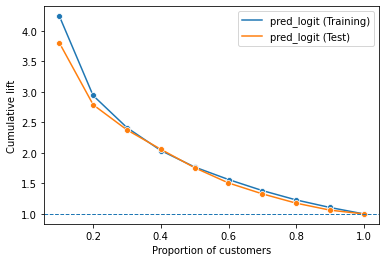

In [17]:
fig = rsm.lift_plot(
    dct,"click","yes","pred_logit",qnt=10
).legend(title=None)

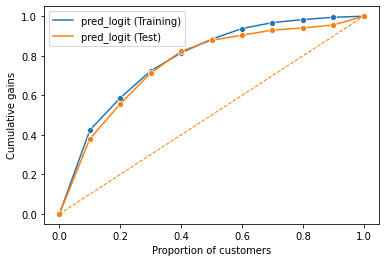

In [18]:
fig = rsm.gains_plot(
    dct,"click","yes","pred_logit",qnt=10
).legend(title=None)

Lift and gains charts look the same for training and test set, which means the current model doesn't have the problem of overfitting

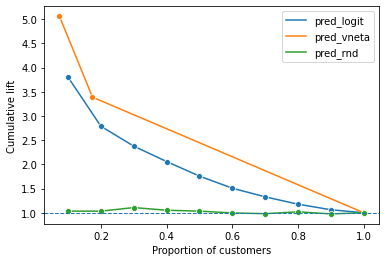

In [19]:
fig = rsm.lift_plot(
    tz_std.query("training=='test'"),
    "click","yes",['pred_logit','pred_vneta','pred_rnd']
).legend(title=None)

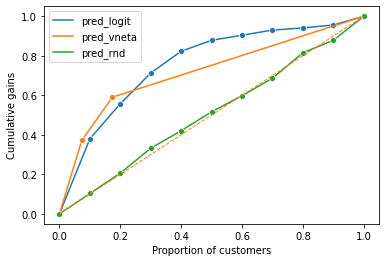

In [20]:
fig = rsm.gains_plot(
    tz_std.query("training=='test'"),
    "click","yes",['pred_logit','pred_vneta','pred_rnd']
).legend(title=None)

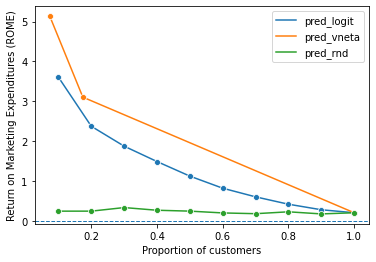

In [21]:
fig = rsm.ROME_plot(
    tz_std.query("training=='test'"),
    "click","yes",['pred_logit','pred_vneta','pred_rnd'],
    cost=0.01,margin=1.25
).legend(title=None)

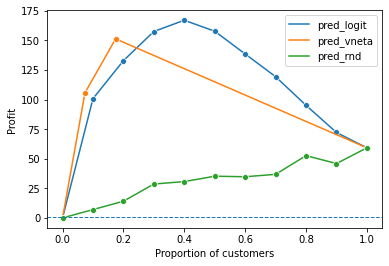

In [22]:
fig = rsm.profit_plot(
    tz_std.query("training=='test'"),
    "click","yes",['pred_logit','pred_vneta','pred_rnd'],
    cost=0.01,margin=1.25
).legend(title=None)

Logistic regression model achieves better profit and ROME compared to status quo, but is worse than the vneta analysis

## Part III: Model comparison 

In [23]:
breakeven = 0.01/1.25

In [24]:
# option1
tz_std["pred_spam"] = 1
tz_std["target_spam"] = True

In [25]:
# option2
tz_std["target_rnd"] = tz_std['pred_rnd']>breakeven

In [26]:
# option3
tz_std["target_logit"] = tz_std['pred_logit']>breakeven

In [27]:
# option4
tz_std["target_vneta"] = tz_std['pred_vneta']>breakeven

In [28]:
tz_gaming_test = tz_std.query("training=='test'")

In [29]:
def profit (col,dat = tz_gaming_test):
    
    total_ad = 20000000
    
    contact = dat[col].mean()
    imp_test = dat[col].sum()
    ctr = dat[dat[col]]['click_yes'].mean()
    clk_test = imp_test*ctr
    
    profit_test = clk_test * 1.25 - imp_test *0.01
    rome_test = profit_test/(imp_test *0.01)
       
    
    
    imp_all = total_ad * contact
    clk_all = imp_all*ctr
    
    profit_all = clk_all * 1.25 - imp_all *0.01
    rome_all = profit_all/(imp_all *0.01)    
    
    return profit_test,rome_test,contact,imp_all,profit_all

In [30]:
profit_spam,rome_spam,contact_spam,imp_spam_20M,profit_spam_20M = profit('target_spam')

In [31]:
profit_rnd,rome_rnd,contact_rnd,imp_rnd_20M,profit_rnd_20M = profit('target_rnd')

In [32]:
profit_logit,rome_logit,contact_logit,imp_logit_20M,profit_logit_20M = profit('target_logit')

In [33]:
profit_vneta,rome_vneta,contact_vneta,imp_vneta_20M,profit_vneta_20M = profit('target_vneta')

In [34]:
temp = {
    "Name":['spam','random','logit','vneta'],
    "Profit":[profit_spam, profit_rnd, profit_logit, profit_vneta],
    "ROME":[rome_spam, rome_rnd, rome_logit, rome_vneta],
    "Contact":[contact_spam, contact_rnd, contact_logit, contact_vneta],
    "Impression_20M":[imp_spam_20M,imp_rnd_20M,imp_logit_20M,imp_vneta_20M],
    "Profit_20M":[profit_spam_20M, profit_rnd_20M,profit_logit_20M, profit_vneta_20M ]
}

In [35]:
df = pd.DataFrame(temp)

In [36]:
df

,Name,Profit,ROME,Contact,Impression_20M,Profit_20M
0,spam,59.22,0.211856,1.000000,2.000000e+07,42371.122956
1,random,59.98,0.215159,0.997281,1.994562e+07,42914.892856
2,logit,167.43,1.538596,0.389296,7.785926e+06,119793.939828
3,vneta,151.29,3.105933,0.174257,3.485136e+06,108245.984331


If Tz-gaming will purchase the 20M impression anyway

In [37]:
bar = 20000000
df_new = df.copy()
df_new['Impression_20M'] = bar
df_new['Profit_20M'] = (bar/df['Impression_20M']) * df_new['Profit_20M'] 

In [38]:
df_new

,Name,Profit,ROME,Contact,Impression_20M,Profit_20M
0,spam,59.22,0.211856,1.000000,20000000,42371.122956
1,random,59.98,0.215159,0.997281,20000000,43031.890089
2,logit,167.43,1.538596,0.389296,20000000,307719.169270
3,vneta,151.29,3.105933,0.174257,20000000,621186.614658


Compare logit with random:

Logit-Random>50K, so the data worth the expense

Compare Vneta data science service with Logit:

Venta-Logit > (150K-50K), so the serive also worth the expense